# Data Science

Debido al requerimiento del cliente, se procederan a reordenar la data, para obtener un set de datos horarios donde cada fila represente la cantidad de viajes realizados en esa hora en especifico(hora de comienzo del viaje).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from funciones import normalize
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [3]:
df.set_index(keys='pickup_datetime',inplace=True)

In [4]:
# Crear un nuevo DataFrame con la cantidad de registros por hora
df_hour = df.resample('30min').size().to_frame('travels')

In [21]:
del df

In [5]:
df_hour.tail(2)

,travels
pickup_datetime,
2024-06-30 23:30:00,818
2024-07-01 00:00:00,2


### <center>Models</center>

Para cumplir con las expectativas del cliente, se evaluaran 2 modelos

- Forecaster Autoregresive: 

Para modelar la evolución de los datos como serie de tiempo, se optó por un modelo Forecaster Autoregresivo que incorpora lags de la variable objetivo y variables de tiempo (como la hora, mes, dia, etc). Esta elección se fundamenta en la hipótesis de que los valores futuros de la serie están fuertemente influenciados por sus valores pasados y por patrones estacionales o cíclicos asociados a las variables de tiempo.

Los lags permiten capturar la autocorrelación presente en la serie, mientras que las variables de tiempo ayudan a modelar los componentes estacionales y de tendencia, lo que resulta en predicciones más precisas y robustas.
Luego de esto se evaluara el desempeño del modelo para su comparacion.

- Modelo de Predicción en Cascada(Autoregresion y Random Forest o regresion lineal multiple):

Para realizar predicciones futuras de la variable objetivo, el modelo se desarrollará en dos etapas. En la primera etapa, se utilizarán modelos predictivos para estimar los valores futuros de las variables auxiliares (ganancia neta, duración del viaje, y CO₂ emitido). Estas estimaciones serán generadas únicamente a partir de valores pasados de cada una de las variables auxiliares, aplicando un modelo autoregresivo puro. Así, para cada variable auxiliar, se entrenará un modelo autoregresivo independiente que capture las tendencias y patrones de su serie temporal individual sin depender de otras variables.

En la segunda etapa, las estimaciones futuras de estas variables auxiliares se utilizarán como entradas (features) en el modelo final. Este modelo tendrá como objetivo principal la predicción de la variable objetivo y empleará tanto los valores estimados de las variables auxiliares como el valor pasado de la variable objetivo para optimizar su precisión en las predicciones futuras. 

******

### <center>Target</center>

El desafio al cual nos ha sometido el cliente, es predecir la demanda de taxis, para lo cual es necesario saber o estimar un valor de cuantos viajes pudieran llegar a realizarse. Por lo cual, se utilizara como target la columna "viajes" creada a partir del recuento de instancias de nuestra data principal transformada en un dataframe con frecuencia horaria.



In [ ]:
#sum_for_price = df['total_price'].resample('30min').sum().to_frame('total_price')
#sum_for_cost = df['fuel_cost'].resample('30min').sum().to_frame('fuel_cost')
#sum_for_profit = df['net_profit'].resample('30min').sum().to_frame('net_profit')
#sum_for_duration = df['trip_duration'].resample('30min').sum().to_frame('trip_duration')
#sum_for_distance = df['trip_distance'].resample('30min').sum().to_frame('trip_distance')
#sum_for_co2 = df['co2'].resample('30min').sum().to_frame('co2')
#print(sum_for_price.dtypes)
#print(sum_for_cost.dtypes)
#print(sum_for_profit.dtypes)
#print(sum_for_duration.dtypes)
#print(sum_for_distance.dtypes)
#sum_for_co2.dtypes
#df_hour = df_hour.join([sum_for_price,sum_for_cost,sum_for_profit,sum_for_duration,sum_for_distance])

In [8]:
df_hour.reset_index(inplace=True)
df_hour['year'] = df_hour['pickup_datetime'].dt.year
df_hour['quarter'] = df_hour['pickup_datetime'].dt.quarter
df_hour['month'] = df_hour['pickup_datetime'].dt.month
df_hour['day_month'] = df_hour['pickup_datetime'].dt.day
df_hour['weekday'] = df_hour['pickup_datetime'].dt.dayofweek
df_hour['hour'] = df_hour['pickup_datetime'].dt.hour
df_hour['weekend'] = df_hour['pickup_datetime'].apply(lambda x: x.weekday() < 5).astype(int) # 1 = weekday, 0 = weekend
#df_hour.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)
df_hour.set_index(keys='pickup_datetime',inplace=True)

In [9]:
df_hour['interval_0_6'] = (df_hour['hour'] >= 0) & (df_hour['hour'] < 6)
df_hour['interval_6_12'] = (df_hour['hour'] >= 6) & (df_hour['hour'] < 12)
df_hour['interval_12_18'] = (df_hour['hour'] >= 12) & (df_hour['hour'] < 18)
df_hour['interval_18_24'] = (df_hour['hour'] >= 18) & (df_hour['hour'] < 24)

df_hour['interval_0_6'] = df_hour['interval_0_6'].astype(int)
df_hour['interval_6_12'] = df_hour['interval_6_12'].astype(int)
df_hour['interval_12_18'] = df_hour['interval_12_18'].astype(int)
df_hour['interval_18_24'] = df_hour['interval_18_24'].astype(int)

# Correlation

Antes de comenzar a implementar los modelos, analizaremos las correlaciones y autocorrelaciones de las diversas variables.

Como nuestro target es la cantidad de viajes realizados en ese determinado momento(ya sea por hora o media hora) se procederan a analizar las correlaciones de esa variable con las variables de tiempo y tambien con nuestras otras variables.

Antes de decidir por el modelo se procederan a ver las correlaciones  de nuestras variables para analizar y descartar las que sean necesarias.

### Dummies Variables

Al dividir la hora del día en intervalos y representarlos con variables booleanas, nuestro modelo puede capturar patrones de comportamiento más precisos y detallados. Esto se debe a que permite identificar variaciones específicas en diferentes momentos del día que podrían no ser evidentes al utilizar la hora como un valor continuo.

Además, al simplificar la representación de la hora, el modelo puede aprender relaciones más claras y evitar suposiciones erróneas sobre la periodicidad. Esta técnica es especialmente útil para identificar picos de demanda, cambios en el comportamiento de los usuarios y otros patrones temporales que son fundamentales para tomar decisiones basadas en datos.




#### Time variables

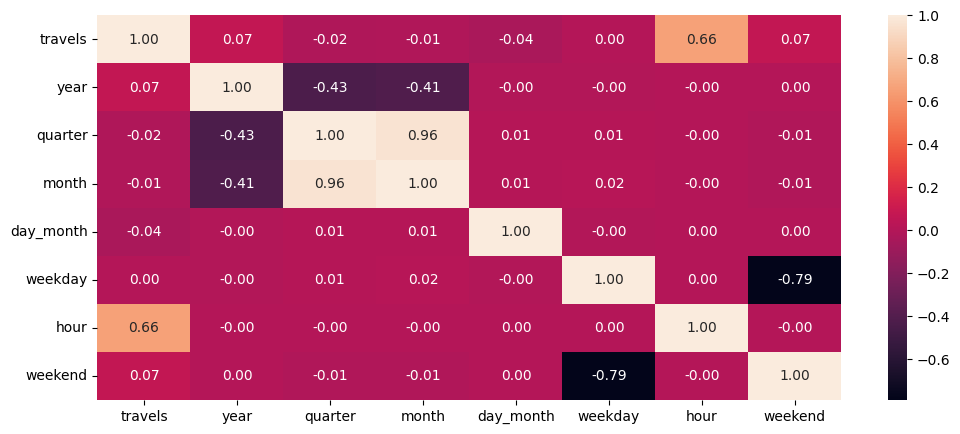

In [84]:
corr = df_hour[['travels', 'year', 'quarter', 'month', 'day_month',
       'weekday', 'hour', 'weekend']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

Se observa que para nuestro target, la variable mas relevante es la hora.

#### Dummies Variables

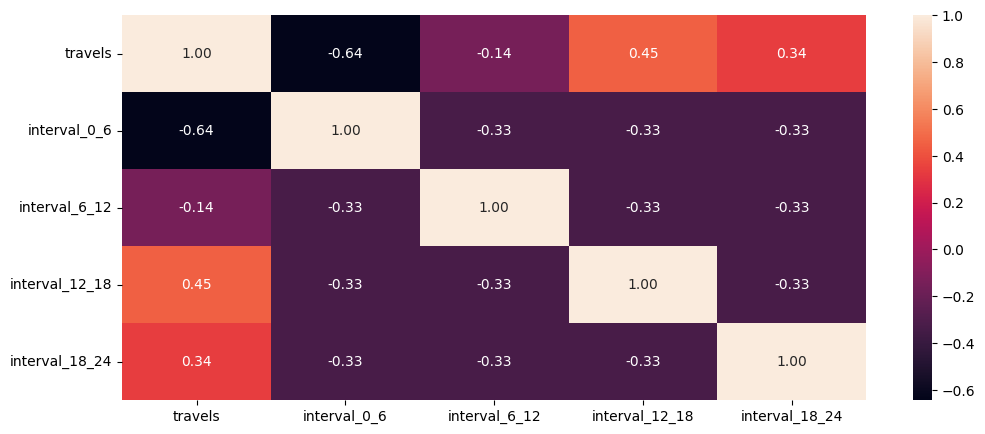

In [85]:
corr = df_hour[['travels','interval_0_6', 'interval_6_12', 'interval_12_18', 'interval_18_24']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

In [18]:
df_hour.columns
df_hour.drop(columns=['year', 'quarter', 'month', 'day_month', 'weekday', 'hour','weekend'],inplace=True)

In [20]:
df_hour.to_parquet('Data/taxis_hour.parquet',engine='pyarrow')

In [22]:
del df_hour
df_hour = pd.read_parquet('Data/taxis_hour.parquet',engine='pyarrow')

# Autocorrelation

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

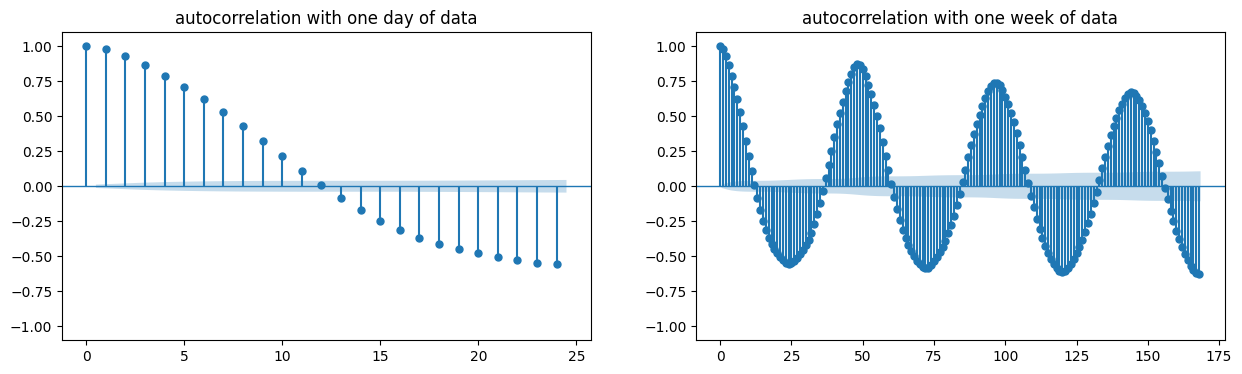

In [24]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_acf(df_hour.travels, ax=axes[0], linewidth = 1, lags=24)
axes[0].set_title("autocorrelation with one day of data")
axes[0].set_ylim(-1.1, 1.1)
plot_acf(df_hour.travels, ax=axes[1], linewidth = 1, lags=168)
axes[1].set_title("autocorrelation with one week of data")
axes[1].set_ylim(-1.1, 1.1)
plt.show()

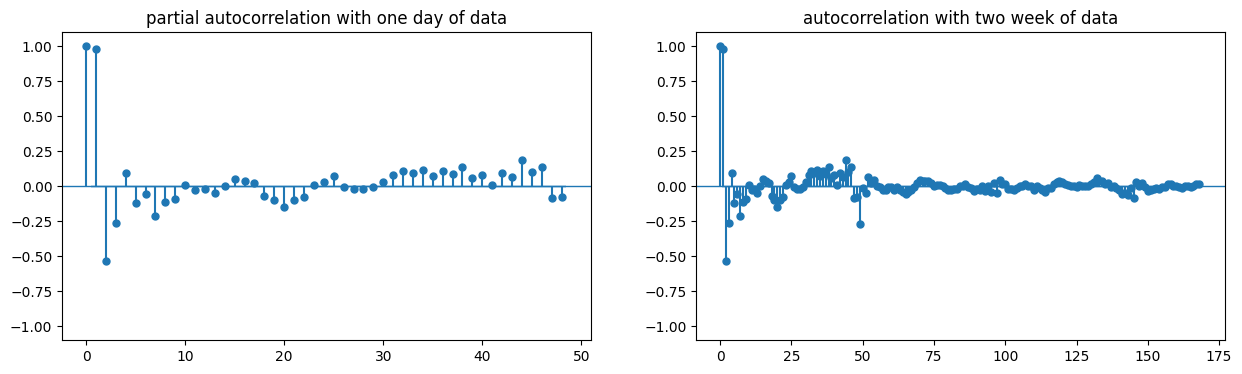

In [25]:

# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_pacf(df_hour.travels, ax=axes[0], linewidth = 1, lags=48)
axes[0].set_title("partial autocorrelation with one day of data")
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(df_hour.travels, ax=axes[1], linewidth = 1, lags=168)
axes[1].set_title("autocorrelation with two week of data")
axes[1].set_ylim(-1.1, 1.1)
plt.show()

El análisis de la autocorrelación (ACF) y la autocorrelación parcial (PACF) de la serie temporal revela características significativas sobre su estructura. En el gráfico de la ACF, se observa un patrón de ondulación sinusoidal que tiende a decrecer hacia cero conforme aumentan los lags, sugiriendo la presencia de una componente estacional. En particular, los picos altos en los lags 12 y 24 indican correlaciones significativas en intervalos recurrentes, lo que sugiere que la serie se comporta de manera similar cada 12 horas, posiblemente influenciada por ciclos diarios o semidiarios, como los datos de actividad humana o variables meteorológicas.

Por otro lado, en el análisis de la PACF, se destaca que los primeros lags, especialmente el primero y el segundo, presentan autocorrelaciones significativas, con una rápida disminución en los siguientes lags, lo que indica que la serie tiene una estructura autoregresiva de bajo orden (AR(1)). Esta fuerte dependencia del valor inmediatamente anterior sugiere que el comportamiento de la serie está determinado en gran medida por su último valor, mientras que la rápida caída en los lags sugiere que esta dependencia disminuye rápidamente.

En conjunto, los resultados indican que la serie temporal presenta una clara estructura autoregresiva y una componente estacional, reflejando patrones recurrentes cada 12 horas. Esto sugiere que el fenómeno analizado está sujeto a influencias cíclicas que se repiten en intervalos regulares, lo que es característico de series temporales con componentes estacionales y autoregresivas.

## First Evaluation - Beta Test

Aplicar el test de beta a una variable antes de utilizar un modelo en ciencia de datos es crucial para evaluar la relevancia de esa variable en el contexto de un análisis de regresión. Este test permite determinar si la variable tiene un efecto significativo sobre la variable dependiente.

Si el coeficiente beta asociado a la variable es estadísticamente significativo, esto indica que hay una relación entre la variable independiente y la dependiente, lo que justifica su inclusión en el modelo. Por otro lado, si no es significativo, podríamos estar añadiendo ruido al modelo, lo que puede llevar a sobreajuste y a una disminución en la capacidad predictiva.

Para poder interpretar de forma correcta los resultados del test de beta, es necesario realizar una normalizacion a los datos.

In [28]:
df_hour.columns

Index(['travels', 'interval_0_6', 'interval_6_12', 'interval_12_18',
       'interval_18_24'],
      dtype='object')

In [29]:
from funciones import normalize
import statsmodels.formula.api as sm
df_hour_norm = normalize(df=df_hour)
model1 = 'travels~interval_0_6+interval_12_18+interval_18_24'
lm1 = sm.ols(formula= model1,data=df_hour_norm).fit()
print(lm1.summary())
del df_hour_norm

                            OLS Regression Results                            
Dep. Variable:                travels   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:06:04   Log-Likelihood:                 16599.
No. Observations:               26257   AIC:                        -3.319e+04
Df Residuals:                   26253   BIC:                        -3.316e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2830      0.002    178.

Como se observa en la imagen, los intervalos de confianza al 95% para todos los coeficientes **no incluyen el valor cero**. Esto indica que, con un nivel de confianza del 95%, podemos afirmar que cada una de las variables independientes (interval_0_6, interval_12_18 e interval_18_24) tiene un efecto estadísticamente significativo sobre la variable dependiente "travels". El hecho de que los intervalos no contengan al cero es una evidencia sólida de que el test beta ha rechazado la hipótesis nula, lo cual significa que las relaciones encontradas no son producto del azar.

En otras palabras, podemos concluir con confianza que las diferentes categorías de intervalos tienen un impacto distinto y significativo en la cantidad de viajes realizados.

## First Aproximation - Autoregresive Model - LGMBRegressor(RandomForest)

Before train the model, we need aply data normalization to scale the metrics in the correct format.

Normalized features can make it easier to interpret the model's coefficients and understand the relative importance of different features.

In [ ]:

df_hour.dropna(axis=0,inplace=True)
df_hour_norm = normalize(df=df_hour)
lags = [1,2,12,24]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)
train_size = int(len(df_hour_norm) * 0.8)
train_data = df_hour_norm['travels'][:train_size]
val_data = df_hour_norm['travels'][train_size:]


# Entrenar el modelo en los datos de entrenamiento
forecaster.fit(y=train_data)
# Predicciones en el conjunto de entrenamiento
train_predictions = forecaster.predict(steps=len(train_data))
# Predicciones en el conjunto de validación
val_predictions = forecaster.predigct(steps=len(val_data))

# Calcular métricas en el conjunto de entrenamiento  "mean_squared_error"
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))
train_mse = metrics.mean_squared_error(train_data, train_predictions)
train_mae = mean_absolute_error(train_data, train_predictions)
train_mape = mean_absolute_percentage_error(train_data, train_predictions)

# Calcular métricas en el conjunto de validación
val_rmse = np.sqrt(mean_squared_error(val_data, val_predictions))
val_mse = metrics.mean_squared_error(val_data, val_predictions)
val_mae = mean_absolute_error(val_data, val_predictions)
val_mape = mean_absolute_percentage_error(val_data, val_predictions)

# Imprimir los resultados
print("Métricas en el conjunto de entrenamiento:")
print(f"RMSE: {train_rmse}")
print(f"MSE: {train_mse}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape}")

print("\nMétricas en el conjunto de validación:")
print(f"RMSE: {val_rmse}")
print(f"MSE: {val_mse}")
print(f"MAE: {val_mae}")
print(f"MAPE: {val_mape}")


Métricas en el conjunto de entrenamiento:
RMSE: 0.2543260421897174
MSE: 0.0646817357358859
MAE: 0.20213889557748135
MAPE: 263747820438.11584

Métricas en el conjunto de validación:
RMSE: 0.2764481595723786
MSE: 0.07642358493095532
MAE: 0.22132961426987885
MAPE: 3.0393710284481363


En el conjunto de entrenamiento, el comando forecaster.predict(steps=len(train_data)) generará predicciones para la longitud de train_data. Así, si train_data abarca n horas, train_predictions contendrá valores para las siguientes n horas, comenzando desde el inicio de train_data.
Para el conjunto de validación, forecaster.predict(steps=len(val_data)) generará predicciones para len(val_data) horas a partir del último valor de train_data, de modo que las predicciones en val_predictions corresponden a las siguientes len(val_data) horas.

In [ ]:

df_pred_train = pd.DataFrame(data=train_predictions)
df_pred_train.columns = ['travels']
df_pred_train.index = train_data.index
df_pred_val = pd.DataFrame(data=val_predictions)
df_pred_val.columns = ['travels']
df_pred_val.index = val_data.index

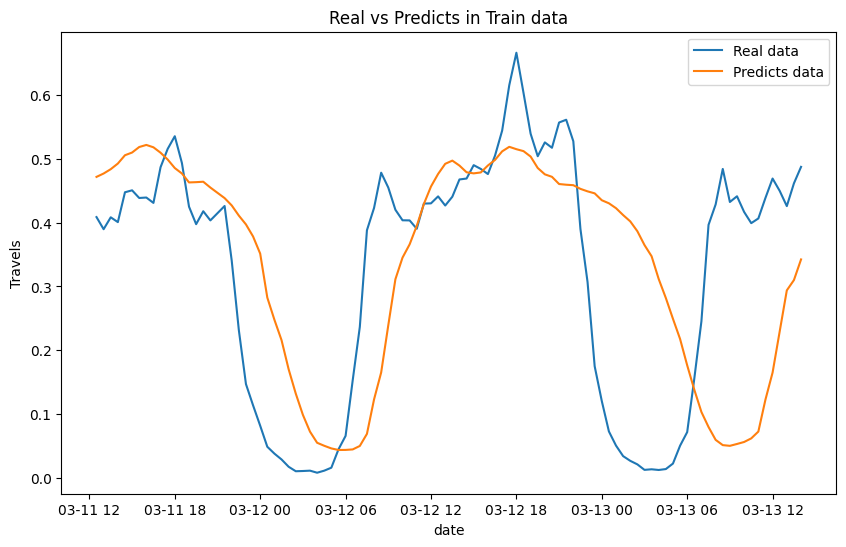

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=train_data[-100:], x=train_data.index[-100:], y=train_data.values[-100:], label="Real data", ax=ax)
sns.lineplot(data=df_pred_train[-100:], x=df_pred_train.index[-100:], y=df_pred_train['travels'][-100:], label="Predicts data", ax=ax)

# Ajustar la visualización
ax.set_title("Real vs Predicts in Train data")
ax.set_xlabel("date")
ax.set_ylabel("Travels")
plt.legend()
plt.show()

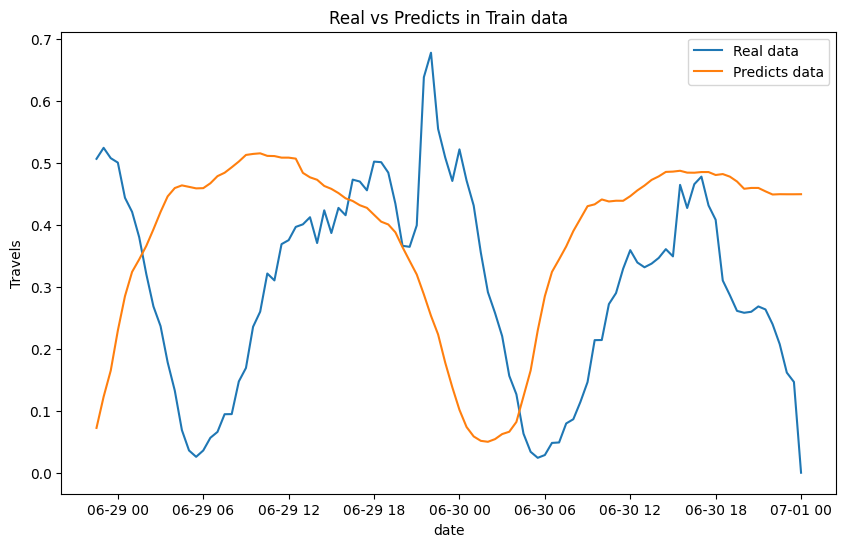

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=val_data[-100:], x=val_data.index[-100:], y=val_data.values[-100:], label="Real data", ax=ax)
sns.lineplot(data=df_pred_val[-100:], x=df_pred_val.index[-100:], y=df_pred_val['travels'][-100:], label="Predicts data", ax=ax)

# Ajustar la visualización
ax.set_title("Real vs Predicts in Train data")
ax.set_xlabel("date")
ax.set_ylabel("Travels")
plt.legend()
plt.show()

## Predicciones en Series Temporales: Enfocándonos en el Futuro

**Generando el horizonte de predicción:**

Para realizar pronósticos en series temporales, es fundamental definir un índice de fechas que abarque tanto los datos históricos como el período futuro que se desea predecir. Este índice servirá como guía para el modelo y garantizará que las predicciones se generen en los momentos temporales correctos donde para nuestro servicio final, se considerara utilizar un marco temporal que abarque el total de 1 semana.

**Utilizando los últimos lags:**

A diferencia de las fases de entrenamiento y validación, donde se dispone de datos para cada instante de tiempo, en la etapa de predicción solo se requiere el valor más reciente (o los últimos valores, según la complejidad del modelo) de la serie temporal. Estos valores pasados servirán como entrada al modelo para extrapolar los valores futuros.

**Especificando el número de pasos a predecir:**

El parámetro `steps` determina la cantidad de períodos en el futuro que se desea pronosticar. Por ejemplo, para predecir las próximas 24 horas, se establecería `steps=24`.

# Time Series Predictions: Focusing on the future

Generation the prediction horizont.


In [ ]:
# Crear el rango de fechas futuras para las próximas 24 horas
last_date = df_hour.index[-1]  # Última fecha conocida en tu serie temporal
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=76, freq='30min')
# Crear el DataFrame con la columna de fecha
future_df = pd.DataFrame({'date': future_dates})
future_df = pd.DataFrame(data=future_dates)
future_df.columns = ['date']
future_df['hour'] = future_df['date'].dt.hour

future_df['interval_0_6'] = (future_df['hour'] >= 0) & (future_df['hour'] < 6)
future_df['interval_6_12'] = (future_df['hour'] >= 6) & (future_df['hour'] < 12)
future_df['interval_12_18'] = (future_df['hour'] >= 12) & (future_df['hour'] < 18)
future_df['interval_18_24'] = (future_df['hour'] >= 18) & (future_df['hour'] < 24)

future_df['interval_0_6'] = future_df['interval_0_6'].astype(int)
future_df['interval_6_12'] = future_df['interval_6_12'].astype(int)
future_df['interval_12_18'] = future_df['interval_12_18'].astype(int)
future_df['interval_18_24'] = future_df['interval_18_24'].astype(int)


# Entrenar el modelo con todos los datos y las variables exógenas
target = df_hour['travels']
exog_vars = ['interval_0_6', 'interval_6_12', 'interval_12_18','interval_18_24']
exog_data = df_hour[exog_vars]

# Crear y entrenar el modelo con todas las observaciones disponibles
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=[1,2,12,24])
forecaster.fit(y=target, exog=exog_data)
future_df.drop(columns=['date','hour'],inplace=True)
n_future_steps = len(future_df)
future_predictions = forecaster.predict(steps=n_future_steps, exog=future_df)

# Crear un DataFrame con las fechas y predicciones futuras
future_df = pd.DataFrame({
    'date': future_dates,
    'Predicción': future_predictions
})


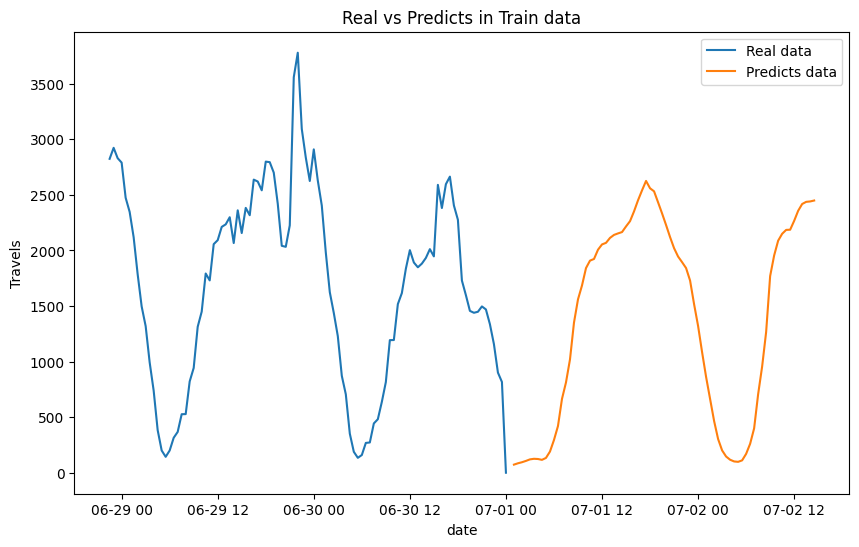

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df_hour[-100:], y=df_hour['travels'][-100:], x=df_hour.index[-100:], label="Real data", ax=ax)
sns.lineplot(data=future_df[-100:], x=future_df['date'][-100:], y=future_df['Predicción'][-100:], label="Predicts data", ax=ax)

# Ajustar la visualización
ax.set_title("Real vs Predicts in Train data")
ax.set_xlabel("date")
ax.set_ylabel("Travels")
plt.legend()
plt.show()